# Capstone 3: *Cancer Gene Expression Classification*
## *Expanded Modeling*
***

## 3.1 Table of Contents<a id='3.1_Contents'></a>
* [3 Preprocessing, Training, and Modeling](#3_Data_wrangling)
  * [3.1 Table of Contents](#3.1_Contents)
  * [3.2 Introduction](#3.2_Introduction)
  * [3.3 Importing the Dependencies](#3.3_Importing_the_Dependencies)
  * [3.4 Importing the Data](#3.4_Importing_the_Data)
  * [3.5 Baseline Model](#3.5_Baseline_Model)
  * [3.6 Additional Models](#3.6_Additional_Models)
  

  

## 3.2 Introduction
<a id='3.2_Introduction'></a>
The baseline model is complete and shows excellent results with the training data.  In this notebook, I will show the baseline model's prediction ability with the test data.  I will then explore additional models - both linear and non linear - and select the best one.  Finally, I will use SHAP for interpreting the data using the best model.

## 3.3 Importing the Dependencies
<a id='3.3_Importing_the_Dependencies'></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb

from matplotlib.lines import Line2D
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import label_binarize
from sklearn.svm import LinearSVC

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
import shap 


#pd.set_option('display.max_rows', 70)

## 3.4 Importing the Data
<a id='3.4_Importing_the_Data'></a>

In [2]:
data = pd.read_csv("../source_data/data.csv")
labels = pd.read_csv("../source_data/labels.csv")

In [3]:
X = pd.read_csv("X.csv")
X_train = pd.read_csv("X_train.csv")
X_test = pd.read_csv("X_test.csv")

In [4]:
#y = np.loadtxt('y.txt')
#y_train = np.loadtxt('y_train.txt')
#y_test = np.loadtxt('y_test.txt')

y = pd.read_csv("y.csv")
y_train = pd.read_csv("y_train.csv")
y_test = pd.read_csv("y_test.csv")

## 3.5 Baseline Model
<a id='3.5_Baseline_Model'></a>

In [5]:
steps = [('pca', PCA(n_components=7)),
         ('clf', LogisticRegression(max_iter = 5000, multi_class='auto'))]
pipe_lr = Pipeline(steps)

pipe_lr.fit(X_train, y_train.values.ravel())
          
y_pred_test_lr = pipe_lr.predict(X_test)
#y_pred_train_lr = pipe_lr.predict(X_train)

print("Test set f1_macro score for baseline model:", f1_score(y_test, y_pred_test_lr, average='macro'))


Test set f1_macro score for baseline model: 0.994710743801653


## 3.6 Additional Models
<a id='3.6_Additional_Models'></a>

### 3.6.1 Linear Models
<a id='3.6.1_Linear_Models'></a>

In [6]:
models = {'Naive Bayes': GaussianNB(),
          'Support Vector Classifier': SVC(max_iter = 5000, random_state=42),}

def execute_linear_model (models):
    
    # Create a dataframe of model names and the mean f1 macro averaged score 
    # across five folds using StratifyKFold

    model_names_list = []
    model_train_means_list = []
    model_test_list = []

    for name, model, in models.items():
        
        # execute each model from list of models
        steps = [('pca', PCA(n_components=7)),
                 ('clf', model)]
        pipe = Pipeline(steps)
        k = 5
        cv = StratifiedKFold(n_splits=k, random_state=42, shuffle=True)
        
        # get the f1 macro averaged score for each fold and then find the mean
        scores_train = cross_val_score(pipe, X_train, y_train.values.ravel(), scoring='f1_macro', cv=cv)
        mean = np.mean(scores_train).round(5)
        
        # appeand the names and means to lists
        model_names_list.append(name)
        model_train_means_list.append(mean)
    
        #scores_test = pipe(X_test, y_test.values.ravel(), scoring='f1_macro')
        pipe.fit(X_train, y_train.values.ravel())
        y_test_pred = pipe.predict(X_test)
        scores_test = f1_score(y_test, y_test_pred, average='macro')
        model_test_list.append(scores_test)
    
    # create a dataframe from the lists
    model_df = pd.DataFrame({'names':model_names_list, 'mean train score': model_train_means_list, 'test score': model_test_list})

    return model_df

# sort the dataframe by mean score in descending order and print
print('Linear model f1 macro scores:')
model_df = execute_linear_model(models)
model_df = model_df.sort_values(by = 'test score', ascending=False)
model_df

Linear model f1 macro scores:


names  mean train score  test score
1  Support Vector Classifier           0.99597    0.994711
0                Naive Bayes           0.98907    0.984753

### 3.6.2 Non-linear Models
<a id='3.6.2_Non-linear_Models'></a>

   **Random Forest**

In [90]:
# working code - rf param search using loops 09 May 23

pca = PCA(n_components=7)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)

def single_rf (n_estimators, max_features, max_depth, min_samples_leaf, min_samples_split, criterion):
    # run a single rf model given parameters and return the oob_error
    clf_rf = RandomForestClassifier(random_state=42, oob_score=True, bootstrap=True, 
                                    max_samples=0.8, warm_start=True, 
                                    n_estimators=n_estimators, max_features=max_features, 
                                    max_depth=max_depth, min_samples_leaf=min_samples_leaf, 
                                    min_samples_split=min_samples_split, criterion=criterion)
    clf_rf.fit(X_train_pca, y_train.values.ravel())

    # Obtain the OOB error
    oob_error = 1 - clf_rf.oob_score_
    return oob_error
  
#n_estimators = [100, 500, 1000, 2000, 3000, 4000, 5000]
#max_features = ['log2', 'sqrt']
#max_depth = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None]
#min_samples_leaf = [1, 2, 4]
#min_samples_split = [2, 5, 10]
#criterion = ['gini', 'entropy', 'log_loss']

n_estimators = [100, 500, 1000, 2000]
max_features = ['log2', 'sqrt']
max_depth = [10, 20, None]
min_samples_leaf = [1, 2, 4]
min_samples_split = [2, 5, 10]
criterion = ['gini', 'entropy', 'log_loss']

error = 100
params_rf = []

for a in n_estimators:
    for b in max_features:
        for c in max_depth:
            for d in min_samples_leaf:
                for e in min_samples_split:
                    for f in criterion:
                        oob_e = single_rf(a, b, c, d, e, f)
                        if oob_e<error:
                            error = oob_e
                            params_rf.clear()
                            params_rf.append(a)
                            params_rf.append(b)
                            params_rf.append(c)
                            params_rf.append(d)
                            params_rf.append(e)
                            params_rf.append(f)
                        else:
                            continue    


param_names_rf = ['n_estimators','max_features','max_depth','min_samples_leaf','min_samples_split','criterion']
best_params_rf = dict(zip(param_names_rf, params_rf))
print('Best rf params:', best_params_rf)
print('\nOOB Error:', error)


Best rf params: {'n_estimators': 1000, 'max_features': 'log2', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'criterion': 'entropy'}

OOB Error: 0.0015625000000000222


**XGBoost**

In [95]:
# modifying rf code for XGBoost 10 May 23
# working but need to check what I'm measuring and reduce runtime

pca = PCA(n_components=7)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)

def single_xgb (max_depth, learning_rate, subsample, gamma, 
                colsample_bytree, min_child_weight):
    # run a single xgb model given parameters and return the error

    clf=XGBClassifier(max_depth=max_depth, learning_rate=learning_rate, 
                      subsample=subsample, gamma=gamma, 
                      colsample_bytree=colsample_bytree, 
                      min_child_weight=min_child_weight, 
                      early_stopping_rounds=10, 
                      eval_metric='merror')
    eval_set = [(X_test, y_test)]
    clf.fit(X_train, y_train.values.ravel(), eval_set=eval_set, verbose=False)

    y_pred = clf.predict(X_test)
    
    # Obtain accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy
        
#max_depth = [3,4,5,6]
#learning_rate = [0.1, 0.2, 0.3, 0.4]
#subsample = [0.5, 1.0, 0.1]
#gamma = [1,2,3, 4, 5, 6, 8, 10, 12, 14, 16, 18, 20]
#colsample_bytree = [0.1, 0.5, 1]
#min_child_weight = [0,1,2,3,4,5,6,7,8,9]

max_depth = [3,4,5,6]
learning_rate = [0.1]
subsample = [0.5]
gamma = [1]
colsample_bytree = [0.1]
min_child_weight = [0,1,2,3,4,5,6,7,8,9]

accuracy = 0
params_xgb = []

for a in max_depth:
    for b in learning_rate:
        for c in subsample:
            for d in gamma:
                for e in colsample_bytree:
                    for f in min_child_weight:
                        acc = single_xgb(a, b, c, d, e, f)
                        if acc>accuracy:
                            
                            accuracy = acc
                            params_xgb.clear()
                            params_xgb.append(a)
                            params_xgb.append(b)
                            params_xgb.append(c)
                            params_xgb.append(d)
                            params_xgb.append(e)
                            params_xgb.append(f)
                        else:
                            continue
    
    
param_names_xgb = ['max_depth','learning_rate','subsample','gamma','colsample_bytree','min_child_weight']
best_params_xgb = dict(zip(param_names_xgb, params_xgb))
print('Best xgb params:', best_params_xgb)
print('\nAccuracy:', accuracy)



Best xgb params: {'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.5, 'gamma': 1, 'colsample_bytree': 0.1, 'min_child_weight': 0}

Accuracy: 1.0


In [100]:
# 22 May 23
# 

pca = PCA(n_components=7)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)

def single_xgb (max_depth, min_child_weight, subsample, colsample_bytree, gamma, learning_rate):
    # run a single xgb model given parameters and return the error

    clf=XGBClassifier(max_depth=max_depth, 
                      min_child_weight=min_child_weight,
                      subsample=subsample, 
                      colsample_bytree=colsample_bytree, 
                      gamma=gamma,
                      learning_rate=learning_rate,  
                      early_stopping_rounds=10, 
                      eval_metric='merror')
    eval_set = [(X_test, y_test)]
    clf.fit(X_train, y_train.values.ravel(), eval_set=eval_set, verbose=False)

    y_pred = clf.predict(X_test)
    
    # Obtain accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy
        
max_depth = [3,4,5,6]
min_child_weight = [0,1,2,3,4,5,6,7,8,9]
#subsample = [1]
#colsample_bytree = [1]
#gamma = [0]
#learning_rate = [0.3]

accuracy = 0
params_xgb = []

max_d = 0
min_cw = 0

for a in max_depth:
    for b in min_child_weight:
        acc = single_xgb(a, b, 1, 1, 0, 0.3)
        
        if acc>accuracy:
                            
            accuracy = acc

            #max_d.clear()
            #min_cw.clear()
            #max_d.append(a)
            #min_cw.append(b)
            max_d = a
            min_cw = b
            
        else:
            continue

print("max_d:", max_d, "min_cw:", min_cw)
                        
#max_depth = max_d
#min_child_weight = min_cw
subsample = [0.5, 1.0, 0.1]
colsample_bytree = [0.1, 0.5, 1]
#gamma = [0]
#learning_rate = [0.3]

accuracy = 0
subsamp = 0
colsamp = 0

for c in subsample:
    for d in colsample_bytree:
        acc = single_xgb(max_d, min_cw, c, d, 0, 0.3)
        
        if acc>accuracy:
                            
            accuracy = acc
            #subsamp.clear()
            #colsamp.clear()
            #subsamp.append(c)
            #colsamp.append(d)
            subsamp = c
            colsamp = d
            
        else:
            continue
                

print("subsamp:", subsamp, "colsamp:", colsamp)
                
#max_depth = max_d
#min_child_weight = min_cw
#subsample = subsamp
#colsample_bytree = colsamp
learning_rate = [0.1, 0.2, 0.3, 0.4]
gamma = [1,2,3, 4, 5, 6, 8, 10, 12, 14, 16, 18, 20]
                
accuracy = 0
learn_r = 0
gam = 0


for e in gamma:
    for f in learning_rate:
        acc = single_xgb(max_d, min_cw, subsamp, colsamp, e, f)
        
        if acc>accuracy:
                            
            accuracy = acc
            #learn_r.clear()
            #gam.clear()
            #learn_r.append(e)
            #gam.append(f)
            learn_r = e
            gam = f
            
        else:
            continue

                
                
print("learn_r:", learn_r, "gam:", gam)
                
max_depth = max_d
min_child_weight = min_cw
subsample = subsamp
colsample_bytree = colsamp
learning_rate = learn_r
gamma = gam

params_xgb.clear()
params_xgb.append(max_depth)
params_xgb.append(min_child_weight)
params_xgb.append(subsample)
params_xgb.append(colsample_bytree)
params_xgb.append(learning_rate)
params_xgb.append(gamma)    

param_names_xgb = ['max_depth','learning_rate','subsample','gamma','colsample_bytree','min_child_weight']
best_params_xgb = dict(zip(param_names_xgb, params_xgb))
print('Best xgb params:', best_params_xgb)
print('\nAccuracy:', accuracy)



max_d: 3 min_cw: 9
subsamp: 0.5 colsamp: 0.1
learn_r: 1 gam: 0.3
Best xgb params: {'max_depth': 3, 'learning_rate': 9, 'subsample': 0.5, 'gamma': 0.1, 'colsample_bytree': 1, 'min_child_weight': 0.3}

Accuracy: 0.9937888198757764


**KNeighborsClassifier**

In [9]:
# knc with randomized search and cross validation
### research scorer_

pca = PCA(n_components=7)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)

param_grid_knc = [{ 
    'n_neighbors': list(range(1,10)),
    'weights': ['uniform','distance'],
    'leaf_size': list(range(2,30)),
    'p': [1,2]
}]

def tune_model (clf, param_grid, score_method):
    # Use randomized search to find best parameters for a model
    
    CV = RandomizedSearchCV(clf, param_grid, scoring = score_method, 
                            n_iter=10, cv=5, n_jobs= 1)
    CV.fit(X_train, y_train.values.ravel())
    
    best_score = CV.best_score_
    best_params = CV.best_params_
    
    return best_score, best_params

best_score_knc, best_params_knc = tune_model(KNeighborsClassifier(), param_grid_knc, 'f1_macro')
### should scoring method be f1_macro here or accuracy?

print('\nBest parameter combination knc:', best_params_knc)
print('Best score knc:', best_score_knc)




Best parameter combination knc: {'weights': 'uniform', 'p': 2, 'n_neighbors': 4, 'leaf_size': 7}
Best score knc: 0.9986987399770906


**The function below gives me the accuracy score but I'd like to get the f1 macro score.**
**PCA?**

In [10]:
pca = PCA(n_components=7)
pca.fit(X_test)
X_test_pca = pca.transform(X_test)

def run_model_with_best_params (model, best_params):
    #run a model with its best parameters
    #find the score for the test set

    model = model
    model.set_params(**best_params)
    model.fit(X_test_pca, y_test.values.ravel())
    score = model.score(X_test_pca, y_test.values.ravel())
    return score
    


In [110]:
# test for using f1 instead of accuracy

#pca = PCA(n_components=7)
#pca.fit(X_test)
#X_test_pca = pca.transform(X_test)

def run_model_with_best_params (model, best_params):
    #run a model with its best parameters
    #find the score for the test set

    model = model
    model.set_params(**best_params)

    steps = [('pca', PCA(n_components=7)),
             ('clf', model)]
    pipe = Pipeline(steps)
    
    pipe.fit(X_train, y_train.values.ravel())
          
    y_pred_test = pipe.predict(X_test)
    score = f1_score(y_test, y_pred_test, average='macro')
    return score

#print("Test set f1_macro score for the model:", f1_score(y_test, y_pred_test, average='macro'))


In [111]:
score_knc = run_model_with_best_params(KNeighborsClassifier(), best_params_knc)
score_knc

0.994710743801653

In [117]:
score_rf = run_model_with_best_params(RandomForestClassifier(random_state=42, oob_score=True, bootstrap=True, 
                                    max_samples=0.8, warm_start=True), best_params_rf)
score_rf

0.9793606076630932

In [119]:
def single_xgb_f1_score (params):
    # run a single xgb model given parameters and return the error

    clf=XGBClassifier(params, early_stopping_rounds=10, 
                      eval_metric='merror')
    eval_set = [(X_test, y_test)]
    clf.fit(X_train, y_train.values.ravel(), eval_set=eval_set, verbose=False)

    y_pred_test = clf.predict(X_test)
    

    f1 = f1_score(y_test, y_pred_test, average='macro')
    return f1

single_xgb_f1_score(best_params_xgb)

0.9812603897742624

**XGB for Interpretability using whole dataset and all columns**

In [14]:
Model_xgbc_all = xgb.XGBClassifier()

In [15]:
Model_xgbc_all.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', ...)

In [16]:
shap.initjs()

In [17]:
explainer = shap.TreeExplainer(Model_xgbc_all)

In [18]:
shap_values = explainer.shap_values(X)



ntree_limit is deprecated, use `iteration_range` or model slicing instead.


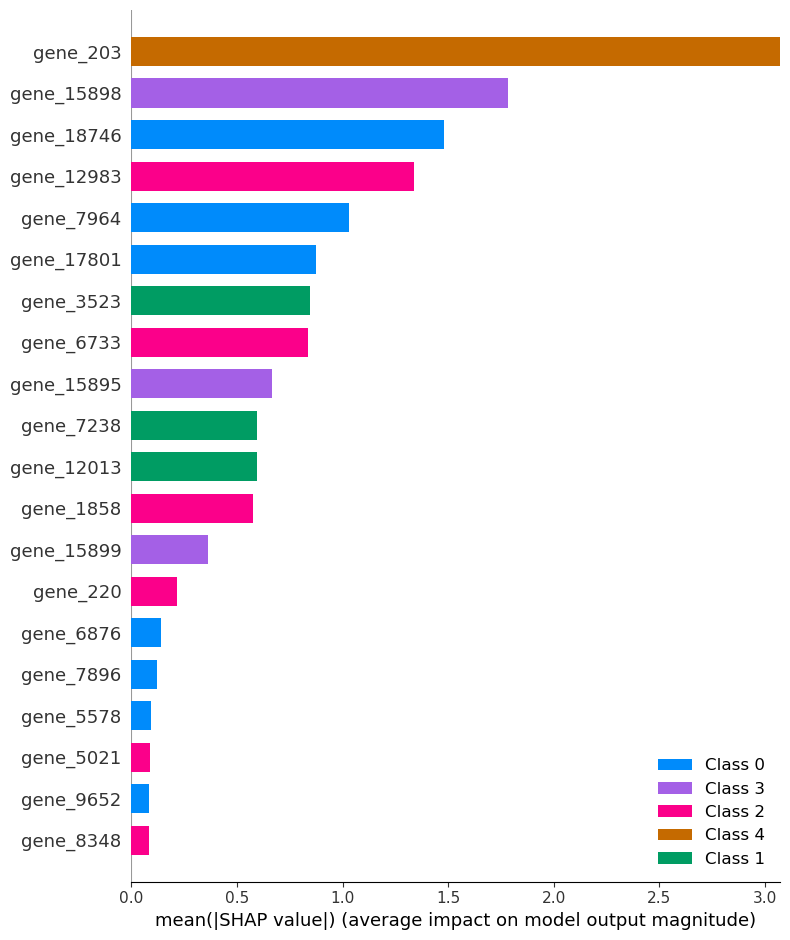

In [19]:
shap.summary_plot(shap_values, X, plot_type="bar")

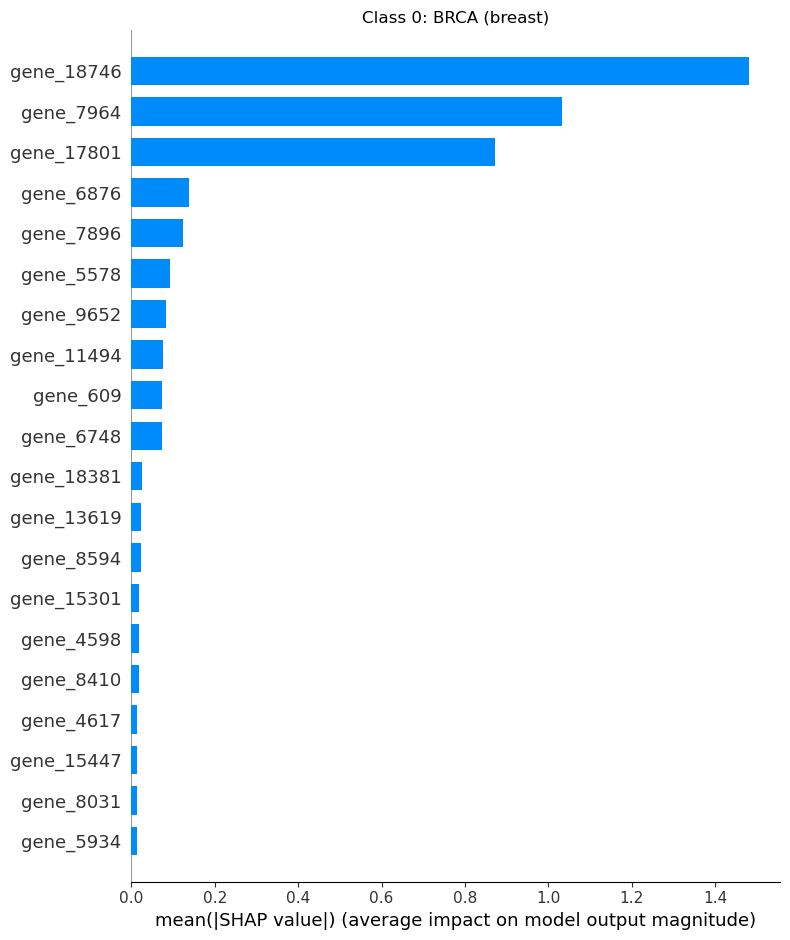

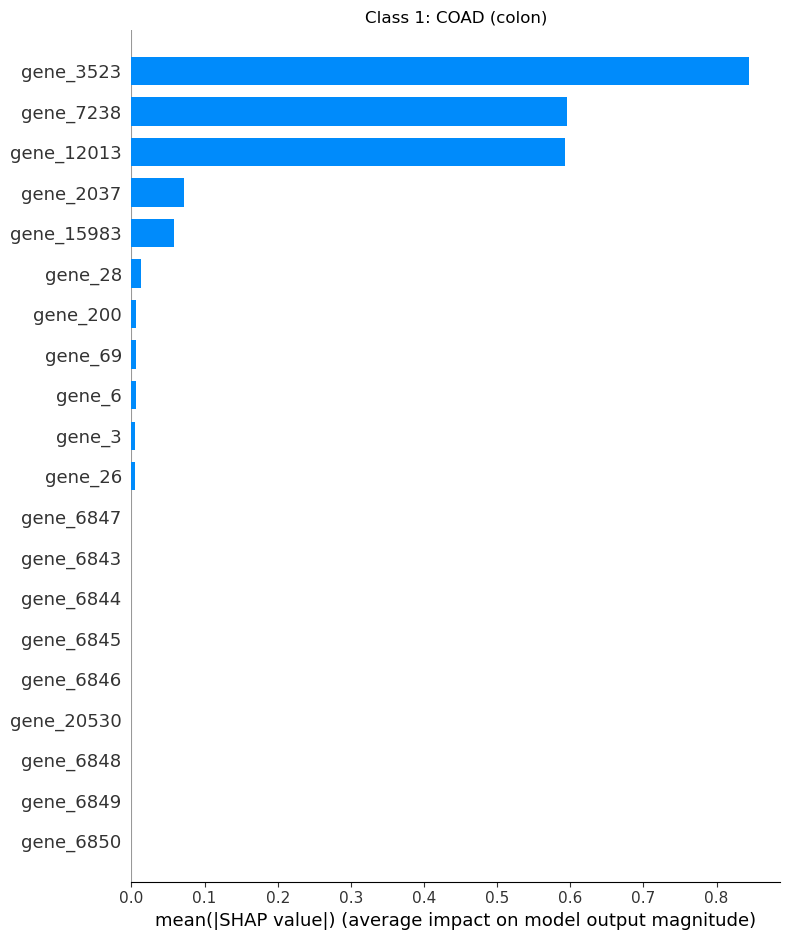

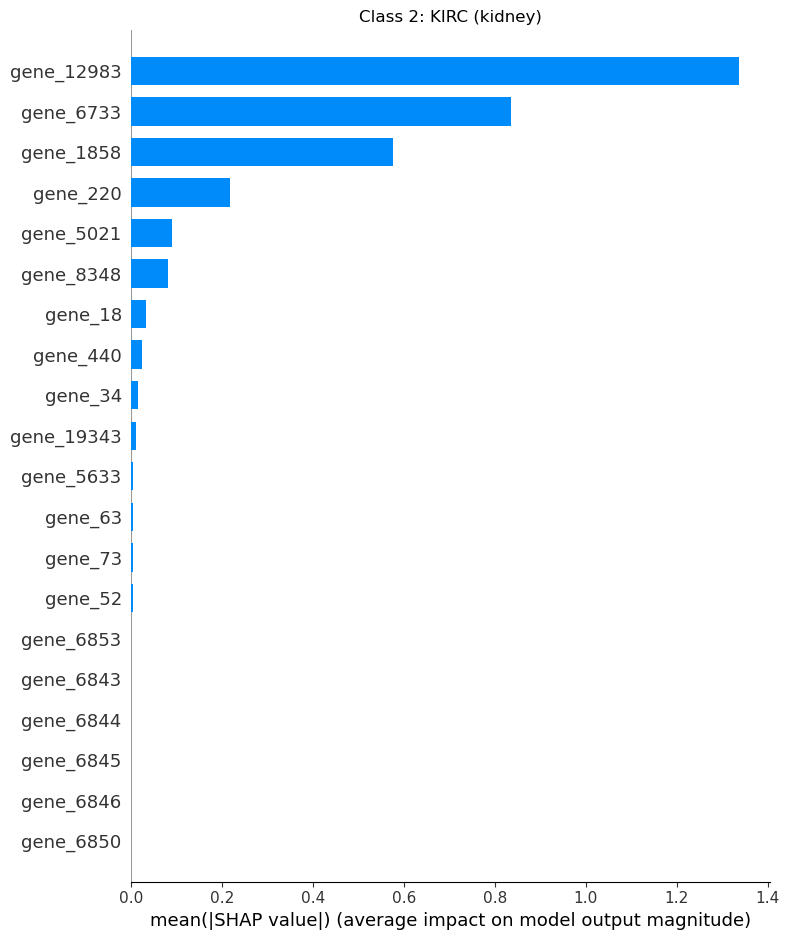

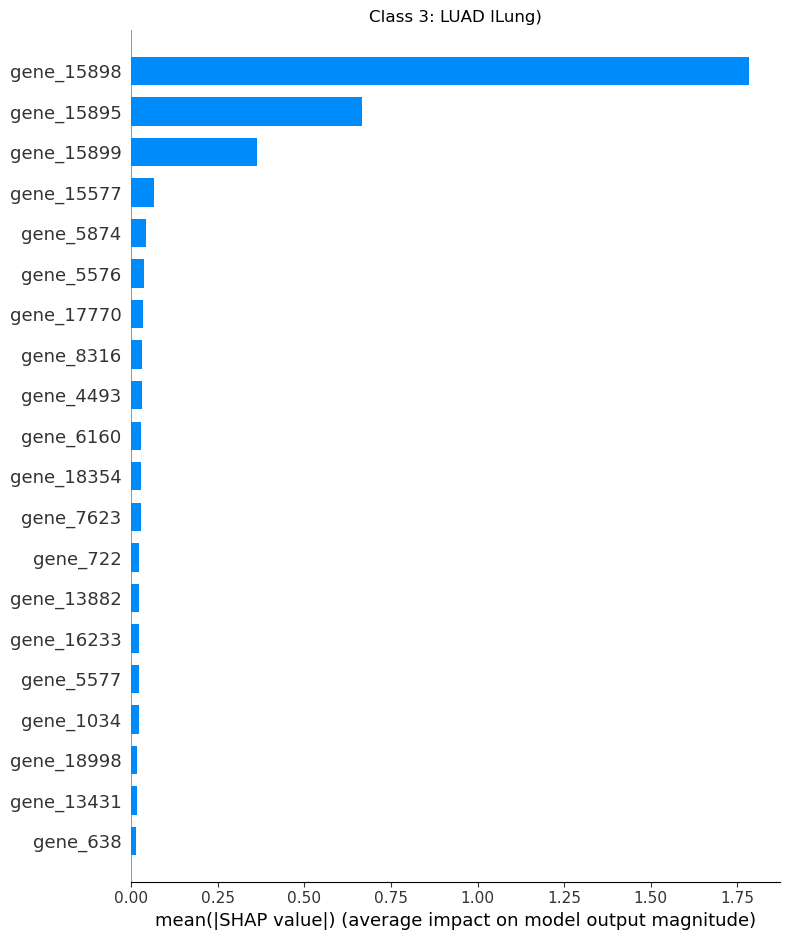

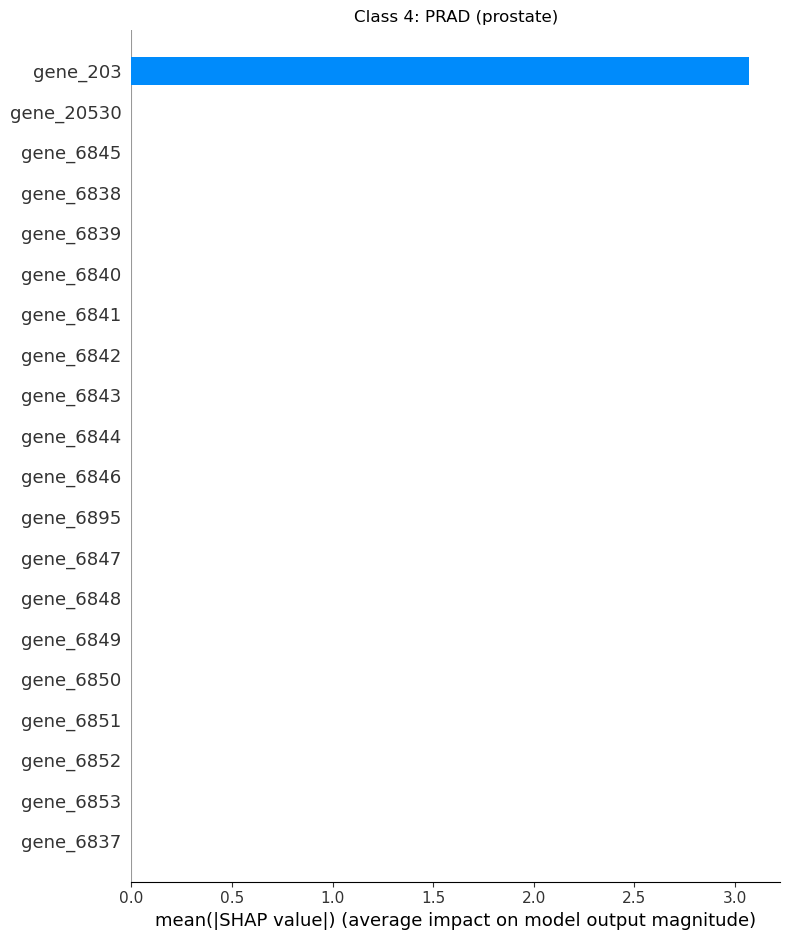

In [20]:
a = ['0: BRCA (breast)','1: COAD (colon)','2: KIRC (kidney)','3: LUAD lLung)','4: PRAD (prostate)']

for i in range(5):
    message = f"Class {a[i]}"
    plt.title(message)
    shap.summary_plot(shap_values[i], X, plot_type="bar")

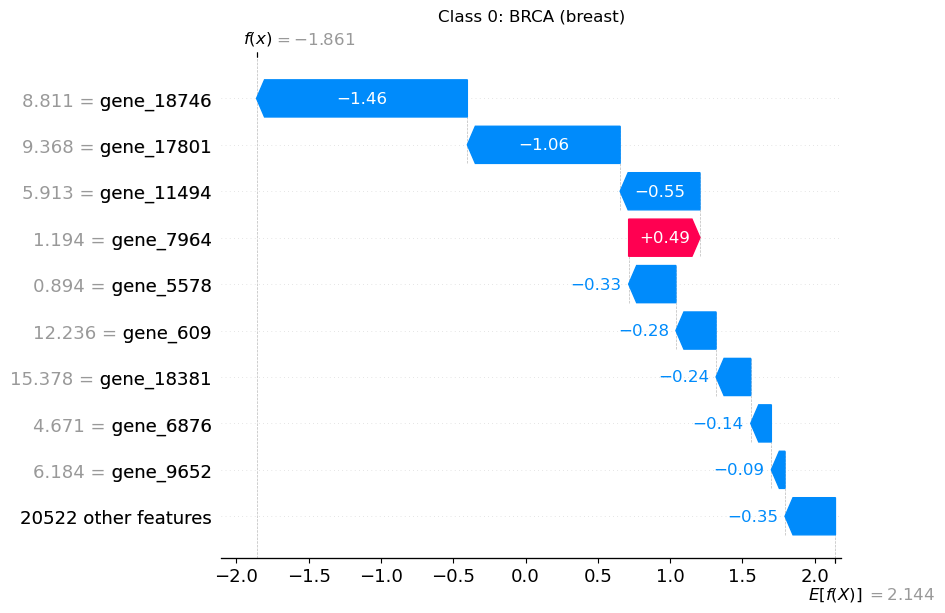

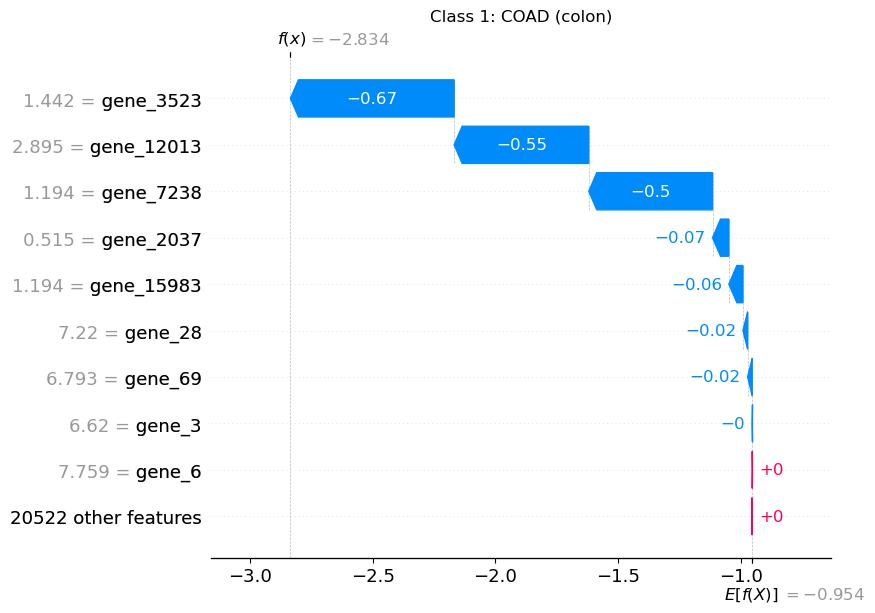

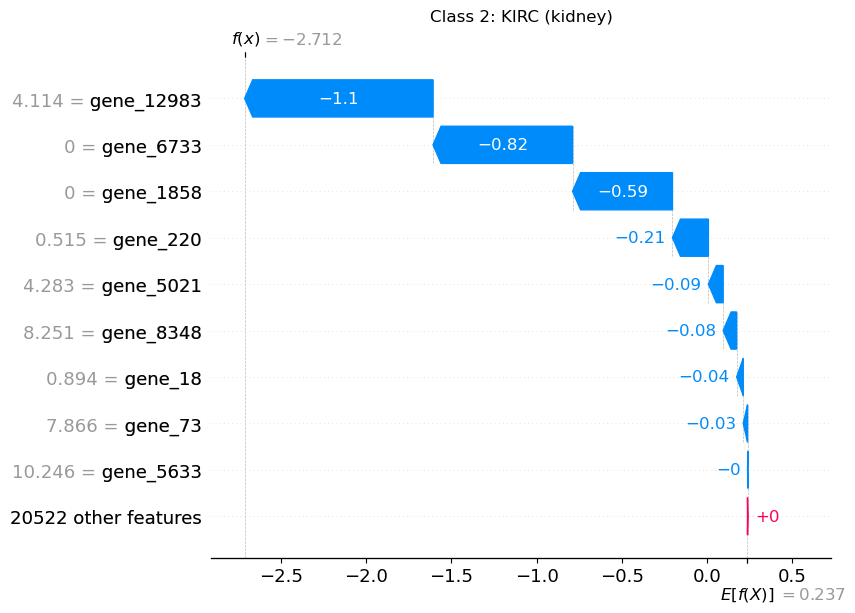

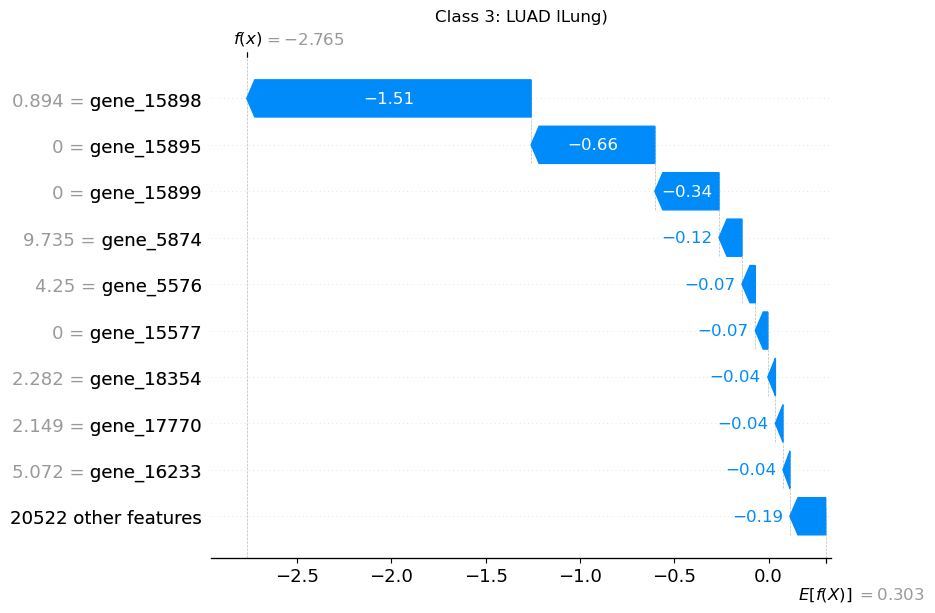

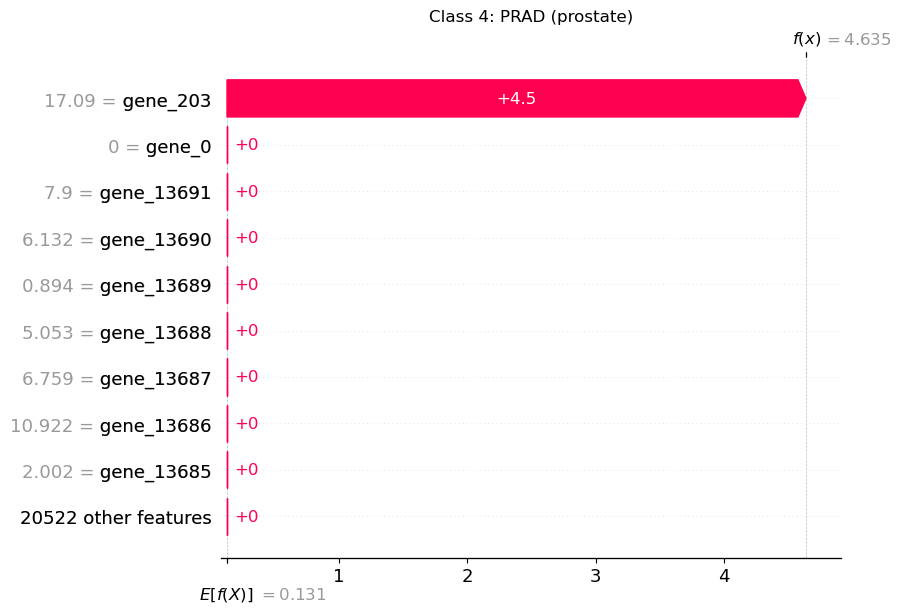

In [21]:
row = 5

for i in range(5):
    message = f"Class {a[i]}"
    plt.title(message)
    shap.waterfall_plot(shap.Explanation(values=shap_values[i][row], 
                                         base_values=explainer.expected_value[i], 
                                         data=X.iloc[row],  
                                         feature_names=X.columns.tolist()))

In [22]:

#for i in range(5):
#    shap.force_plot(explainer.expected_value[i], shap_values[i], X)

#shap.force_plot(explainer.expected_value[0], shap_values[0], X)

In [23]:
#display(shap.force_plot(explainer.expected_value[0], shap_values[0], X))

In [43]:
y_0 = y.index[y['Class']==0].min().tolist()
y_1 = y.index[y['Class']==1].min().tolist()
y_2 = y.index[y['Class']==2].min().tolist()
y_3 = y.index[y['Class']==3].min().tolist()
y_4 = y.index[y['Class']==4].min().tolist()

ys = ['y_0','y_1','y_2','y_3','y_4']

In [60]:
#row = 0
#for i in range(5):
#    shap.force_plot(explainer.expected_value[i], shap_values[i][row], X.values[row], feature_names = X.columns)

#for i in range(5):
#    shap.force_plot(explainer.expected_value[i], shap_values[i][row], X.values[row], feature_names = X.columns)

In [70]:
#row = 0

In [64]:
shap.initjs()
print("Contributing Features for Single Model Prediction in Class 0: BRCA (breast)")
shap.force_plot(explainer.expected_value[0], shap_values[0][y_0], X.values[y_0], feature_names = X.columns)

Contributing Features for Single Model Prediction in Class 0: BRCA (breast)


In [65]:
shap.initjs()
print("Contributing Features for Single Model Prediction in Class 1: COAD (colon)")
shap.force_plot(explainer.expected_value[1], shap_values[1][y_1], X.values[y_1], feature_names = X.columns)

Contributing Features for Single Model Prediction in Class 1: COAD (colon)


In [66]:
shap.initjs()
print("Contributing Features for Single Model Prediction in Class 2: KIRC (kidney)")
shap.force_plot(explainer.expected_value[2], shap_values[2][y_2], X.values[y_2], feature_names = X.columns)

Contributing Features for Single Model Prediction in Class 2: KIRC (kidney)


In [67]:
shap.initjs()
print("Contributing Features for Single Model Prediction in Class 3: LUAD (lung)")
shap.force_plot(explainer.expected_value[3], shap_values[3][y_3], X.values[y_3], feature_names = X.columns)

Contributing Features for Single Model Prediction in Class 3: LUAD (lung)


In [72]:
shap.initjs()
print("Contributing Features for Single Model Prediction in Class 4: PRAD (prostate)")
shap.force_plot(explainer.expected_value[4], shap_values[4][y_4], X.values[y_4], feature_names = X.columns)

Contributing Features for Single Model Prediction in Class 4: PRAD (prostate)


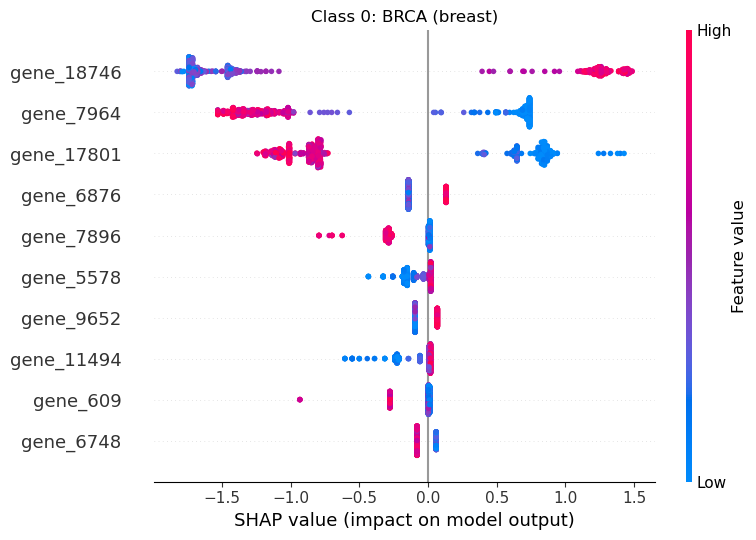

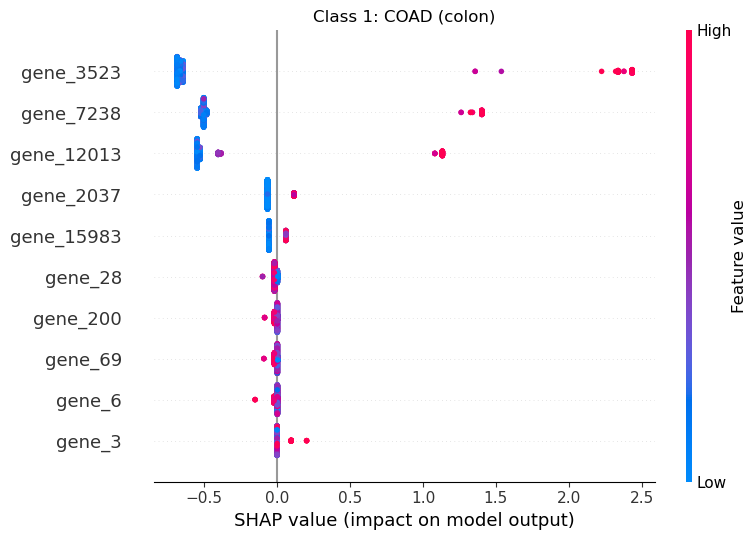

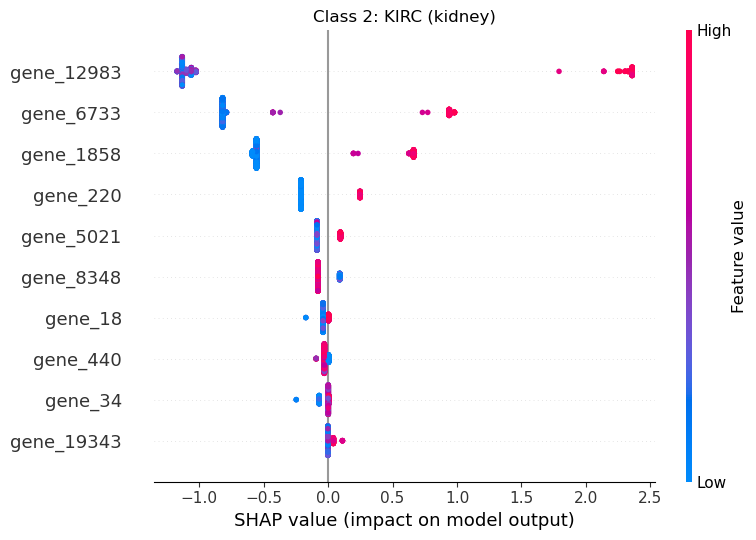

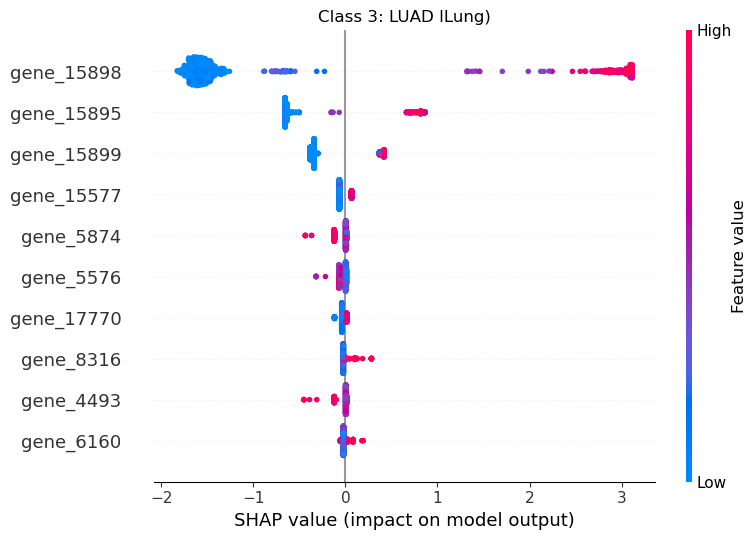

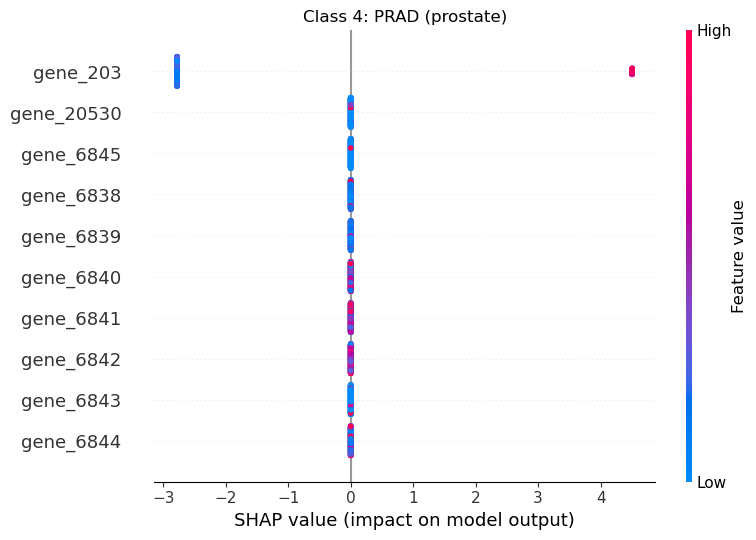

In [31]:
for i in range(5):
    message = f"Class {a[i]}"
    plt.title(message)
    shap.summary_plot(shap_values[i], X, max_display=10)


#for i in list(range(5)):
#    print("Summary Plot for Class", i)
#    shap.summary_plot(shap_values[i], X, max_display=10)